In [82]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
%matplotlib inline
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist # computing the distance
from scipy.cluster.hierarchy import inconsistent
from scipy.cluster.hierarchy import fcluster
from pyclustertend import hopkins

In [83]:
data = pd.read_csv('Data/PCA_data.csv')
#data.drop('Unnamed: 0', axis = 1, inplace = True)
print(data.shape)
data.head()

(388, 9)


,PC1,PC2,PC3,PC4,PC5,PC6,PLAYER,TEAM,POSITION
0,6.291071,3.121701,2.015822,-1.350079,-0.373852,-1.428919,James Harden,HOU,G
1,5.091072,1.872966,-2.228311,-0.918732,0.316974,0.382151,Paul George,OKC,F
2,2.954488,4.665338,-0.565792,-1.409980,-0.173282,-0.723689,Giannis Antetokounmpo,MIL,F
3,1.507232,6.402759,-0.889439,0.042329,-0.144953,-1.370480,Joel Embiid,PHI,F-C
4,4.200132,2.578374,0.705661,-1.783460,1.026415,-1.540215,LeBron James,LAL,F


In [84]:
def Standard_Scaler_Preprocess(data):    
    std_scale = StandardScaler()
    std_scale_data = std_scale.fit_transform(data.drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1))
    std_scale_data = pd.DataFrame(std_scale_data, columns = data.drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1).columns.tolist())
    std_scale_data['PLAYER'] = data['PLAYER']
    std_scale_data['TEAM'] = data['TEAM']
    std_scale_data['POSITION'] = data['POSITION']
    return std_scale_data

data_scaled = Standard_Scaler_Preprocess(data)
data_scaled.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PLAYER,TEAM,POSITION
0,2.931592,1.522749,1.354774,-1.229530,-0.348220,-1.421312,James Harden,HOU,G
1,2.372402,0.913623,-1.497582,-0.836698,0.295241,0.380116,Paul George,OKC,F
2,1.376769,2.275728,-0.380252,-1.284083,-0.161401,-0.719837,Giannis Antetokounmpo,MIL,F
3,0.702359,3.123232,-0.597765,0.038549,-0.135015,-1.363184,Joel Embiid,PHI,F-C
4,1.957230,1.257717,0.474254,-1.624215,0.956039,-1.532015,LeBron James,LAL,F


In [85]:
data_scaled.describe().round(1)

,PC1,PC2,PC3,PC4,PC5,PC6
count,388.0,388.0,388.0,388.0,388.0,388.0
mean,-0.0,-0.0,0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0
min,-2.2,-2.1,-2.3,-2.7,-3.3,-3.5
25%,-0.7,-0.7,-0.7,-0.7,-0.6,-0.7
50%,-0.1,-0.2,-0.0,-0.0,-0.1,-0.0
75%,0.6,0.5,0.6,0.6,0.4,0.6
max,2.9,3.5,3.2,3.6,5.7,3.5


In [86]:
num_data_scaled = data_scaled.drop(['PLAYER', 'POSITION', 'TEAM'], axis = 1)
num_data_scaled.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], dtype='object')

In [87]:
hopkins(num_data_scaled, num_data_scaled.shape[0])

0.2830738703230449

In [88]:
class cluster:
    def __init__(self, method):
        self.method = method
        self.linked = linkage(num_data_scaled, self.method)


    def cophenet_value(self):
        c, coph_dists = cophenet(self.linked, pdist(num_data_scaled))
        return c
    

    def dendrogram_plot(self):
        plt.figure(figsize=(15, 6)) 
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('States')
        plt.ylabel('distance')
        dendrogram(self.linked,
                   orientation='top', #The direction to plot the dendrogram
                              #The root at the top, and descendent links going downwards
                   #labels=statesList,
                   distance_sort='descending',
                   show_leaf_counts=True)
        plt.show()

    def dendrogram_truncated(self, n, y_min = 0, max_d = 0):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        dendro = dendrogram(
                    self.linked,
                    truncate_mode='lastp',  # show only the last p merged clusters
                    p=n,  # show only the last p merged clusters
                    leaf_rotation=90.,
                    leaf_font_size=12.,
                    show_contracted=True,  # to get a distribution impression in truncated branches
                )

        for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            #if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                         textcoords='offset points',
                         va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')

        plt.ylim(ymin = y_min)
        plt.show()


    def inconsistency(self):
        depth = 3
        incons = inconsistent(self.linked, depth)
        return incons[-15:]


    def elbow_plot(self, cut = 0):
        last = self.linked[(-1*cut):, 2]
        last_rev = last[::-1]
        idxs = np.arange(1, len(last) + 1)
        plt.plot(idxs, last_rev)

        acceleration = np.diff(last, 2)  # 2nd derivative of the distances
        self.acceleration_rev = acceleration[::-1]
        plt.plot(idxs[:-2] + 1, self.acceleration_rev)
        plt.show()
    

    def elbow_point(self):
        k = self.acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
        return k

    
    def create_cluster(self, max_d):
        clusters = fcluster(self.linked, max_d, criterion='distance')
        return clusters


0.418114456187473


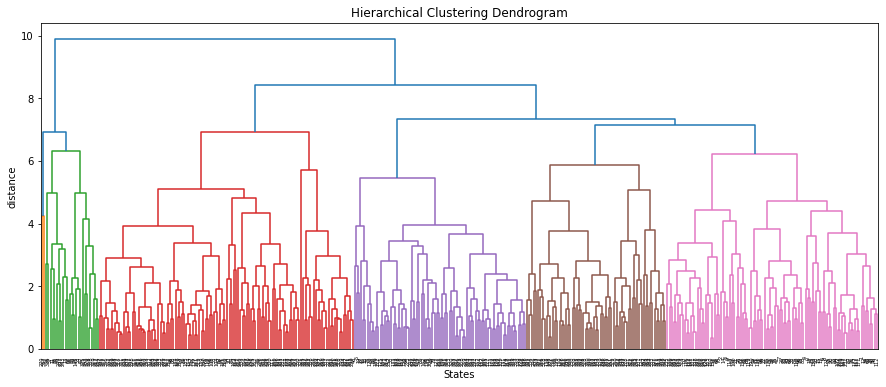

In [89]:
complete = cluster('complete')
print(complete.cophenet_value())
complete.dendrogram_plot()

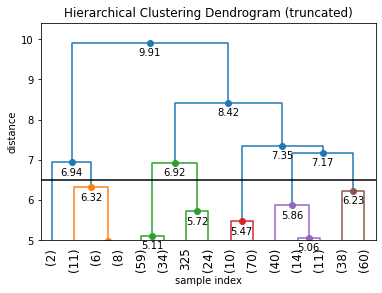

In [90]:
complete.dendrogram_truncated(15, 5, 6.5)

In [91]:
complete.inconsistency()

array([[3.35881723, 0.96647859, 5.        , 1.6779403 ],
       [3.06648243, 1.30724398, 6.        , 1.46835627],
       [3.20928787, 0.99960111, 7.        , 1.85628092],
       [3.97477845, 0.81787475, 7.        , 1.38619179],
       [3.70880706, 0.92699995, 7.        , 1.89541123],
       [3.68448554, 1.48737265, 4.        , 1.36582668],
       [4.14970606, 1.15420458, 7.        , 1.48433124],
       [4.44723946, 0.90082298, 7.        , 1.98163689],
       [4.11045578, 1.43156729, 7.        , 1.54041601],
       [5.04408432, 1.17273148, 6.        , 1.60064053],
       [5.49136856, 1.10343673, 5.        , 1.3122744 ],
       [5.45867897, 0.99730411, 7.        , 1.71340934],
       [5.70960175, 1.37690795, 7.        , 1.18818386],
       [6.59208877, 1.1962004 , 7.        , 1.52808375],
       [7.15539496, 1.75879356, 7.        , 1.56653363]])

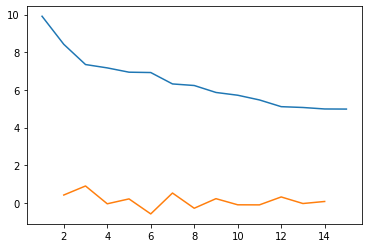

In [92]:
complete.elbow_plot(15)

In [93]:
complete.elbow_point()

3

In [94]:
data_scaled['complete_cluster'] = complete.create_cluster(6.5)

In [95]:
data_scaled.groupby('complete_cluster').mean()

,PC1,PC2,PC3,PC4,PC5,PC6
complete_cluster,,,,,,
1,-1.231619,-0.192474,0.772417,-0.233801,4.933519,1.916498
2,-0.297911,0.862575,0.587760,0.016632,1.448102,0.776367
3,-0.311373,-0.192350,-0.534208,-0.649451,-0.389772,0.612514
4,-0.134601,-0.891329,1.438104,0.381035,-0.822064,-0.082634
5,0.269141,-0.469109,-0.561415,1.038778,0.130166,0.117703
6,-0.573802,-0.391968,0.255654,-0.505230,0.453129,-1.176360
7,0.591833,0.836725,0.263118,0.006761,-0.297305,-0.113194


In [96]:
data_scaled['complete_cluster'].value_counts()

7    98
3    93
5    80
6    65
4    25
2    25
1     2
Name: complete_cluster, dtype: int64

0.6544531572603184


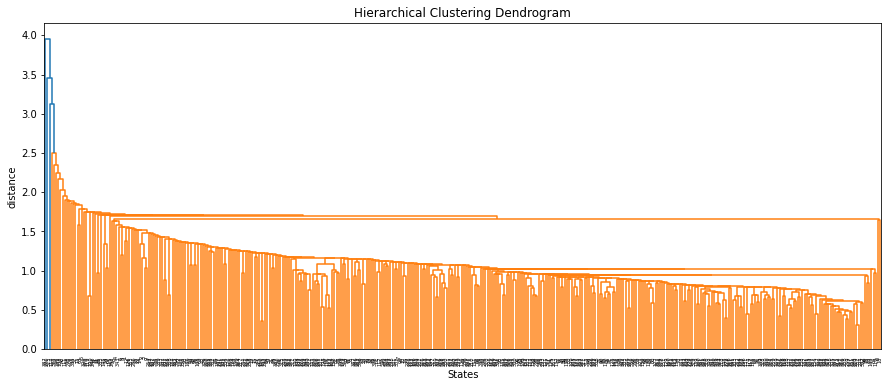

In [97]:
single = cluster('single')
print(single.cophenet_value())
single.dendrogram_plot()

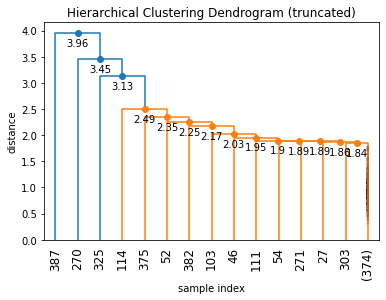

In [98]:
single.dendrogram_truncated(15)

In [99]:
single.inconsistency()

array([[1.74570703, 0.11067233, 4.        , 0.80702728],
       [1.82070809, 0.03323802, 3.        , 0.71251016],
       [1.84651384, 0.01268684, 3.        , 1.07312211],
       [1.86319212, 0.02050586, 3.        , 1.06629791],
       [1.87939859, 0.01715565, 3.        , 0.79340241],
       [1.89202154, 0.00652625, 3.        , 0.91563801],
       [1.91505892, 0.03396252, 3.        , 1.15158382],
       [1.95949465, 0.06432546, 3.        , 1.03881825],
       [2.05031829, 0.1101286 , 3.        , 1.09099603],
       [2.14728067, 0.11119802, 3.        , 0.8792968 ],
       [2.25484065, 0.08966568, 3.        , 1.05008291],
       [2.36298483, 0.12550795, 3.        , 1.05105591],
       [2.65811116, 0.41549952, 3.        , 1.13676324],
       [3.02514002, 0.48621908, 3.        , 0.87397557],
       [3.51299165, 0.41757906, 3.        , 1.06677745]])

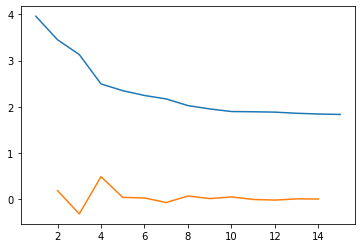

4


In [100]:
single.elbow_plot(15)
print(single.elbow_point())

0.6397454586656233


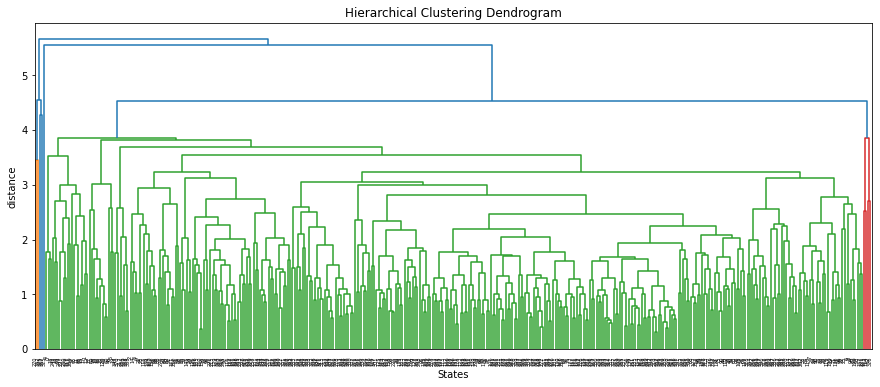

In [101]:
average = cluster('average')
print(average.cophenet_value())
average.dendrogram_plot()

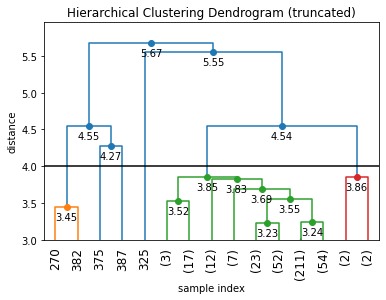

In [102]:
average.dendrogram_truncated(15, 3, 4)

In [103]:
average.inconsistency()

array([[2.52935002, 0.37376044, 7.        , 1.61557639],
       [2.74396143, 0.41236566, 7.        , 1.18472682],
       [2.90620463, 0.26792122, 7.        , 1.2516037 ],
       [3.45008362, 0.        , 1.        , 0.        ],
       [2.58114537, 0.7286936 , 6.        , 1.29144888],
       [3.18191039, 0.1905706 , 7.        , 1.92241984],
       [2.86753314, 0.75645349, 7.        , 1.08528456],
       [3.10998012, 0.56950325, 7.        , 1.26299258],
       [3.24023076, 0.73480028, 7.        , 0.8364561 ],
       [3.02740157, 0.72407222, 3.        , 1.14584079],
       [4.27172238, 0.        , 1.        , 0.        ],
       [3.54697065, 0.70947497, 7.        , 1.40002943],
       [4.09134134, 0.57278098, 3.        , 0.80462987],
       [4.45136703, 0.8023133 , 4.        , 1.37341932],
       [4.67365123, 0.83262757, 6.        , 1.20185313]])

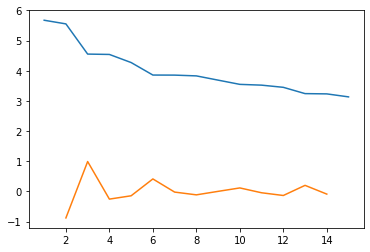

3


In [104]:
average.elbow_plot(15)
print(average.elbow_point())

In [105]:
data_scaled['average_cluster'] = average.create_cluster(4)

In [106]:
data_scaled.groupby('average_cluster').mean()

,PC1,PC2,PC3,PC4,PC5,PC6,complete_cluster
average_cluster,,,,,,,
1,-0.600392,-1.068467,0.125628,-0.800144,4.457306,0.007236,3.500000
2,-1.894414,0.141139,3.156672,1.109100,3.019681,-0.181725,2.000000
3,-1.692286,-0.379656,1.656533,0.237750,4.122024,3.521072,1.000000
4,0.017113,0.005933,-0.002542,0.011036,-0.038619,-0.041233,4.968338
5,-0.009655,-0.198368,-1.141100,-1.658531,0.469365,2.568352,2.500000
6,-1.659747,0.920499,0.463222,2.704874,-3.297274,2.000091,4.000000


In [107]:
data_scaled['average_cluster'].value_counts()

4    379
5      4
1      2
6      1
3      1
2      1
Name: average_cluster, dtype: int64

0.4115882361771967


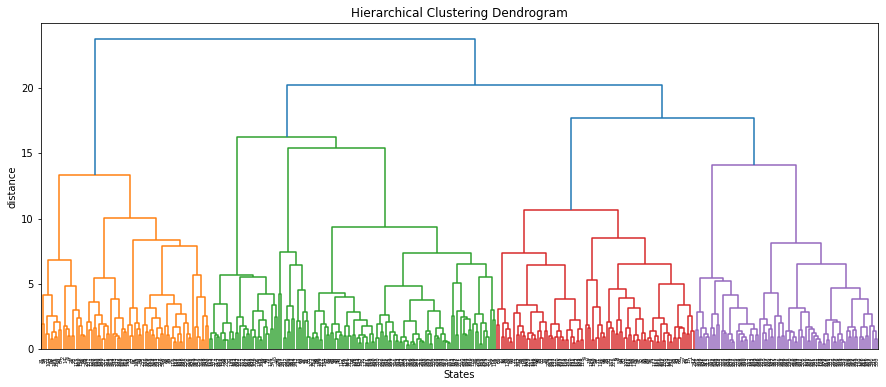

In [108]:
ward = cluster('ward')
print(ward.cophenet_value())
ward.dendrogram_plot()

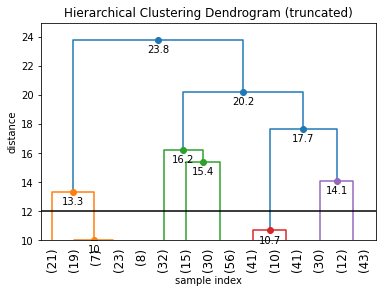

In [109]:
ward.dendrogram_truncated(15, 10, 12)

In [110]:
ward.inconsistency()

array([[ 5.17018587,  1.69412964,  5.        ,  1.31897556],
       [ 4.72081822,  1.78533833,  6.        ,  1.78075135],
       [ 4.54033363,  2.1544091 ,  7.        ,  1.68287676],
       [ 4.72444162,  2.67538565,  7.        ,  1.36228202],
       [ 5.00116613,  2.14995355,  7.        ,  1.61848443],
       [ 5.61725638,  2.2420163 ,  7.        ,  1.67807142],
       [ 6.05893191,  2.71043659,  7.        ,  1.46587012],
       [ 6.8401449 ,  2.3990713 ,  7.        ,  1.60597421],
       [ 7.5663342 ,  3.27896344,  7.        ,  1.76165968],
       [ 6.66468828,  3.68229832,  7.        ,  2.02315317],
       [ 7.7831239 ,  3.83035029,  7.        ,  1.99491655],
       [ 9.01472837,  5.002747  ,  7.        ,  1.44269596],
       [10.27255749,  4.27813965,  7.        ,  1.73514405],
       [14.29658062,  4.80095657,  7.        ,  1.23129519],
       [15.44436369,  5.86192549,  7.        ,  1.42308477]])

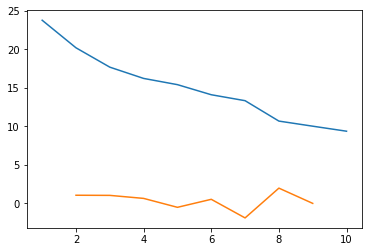

8


In [111]:
ward.elbow_plot(10)
print(ward.elbow_point())

In [112]:
data_scaled['ward_cluster'] = ward.create_cluster(12)

In [113]:
data_scaled.groupby('ward_cluster').mean()

,PC1,PC2,PC3,PC4,PC5,PC6,complete_cluster,average_cluster
ward_cluster,,,,,,,,
1,0.091334,1.884367,-0.525754,-0.300788,-0.851365,-0.269122,5.285714,4.000000
2,-1.254168,1.173279,0.741630,0.459303,0.269682,-0.060140,5.192982,4.000000
3,0.308488,-0.616709,-1.264813,1.431996,0.465607,-0.076242,5.000000,4.000000
4,0.365819,-0.067761,0.193473,-0.983806,2.529068,0.293747,2.933333,3.533333
5,-0.333446,-0.160568,-0.811543,-0.486182,-0.189518,0.703106,3.662791,4.046512
6,1.180289,-0.026847,0.383642,0.220926,-0.211537,-0.001944,6.184783,4.000000
7,-0.655424,-0.724626,-0.552281,-0.619717,0.028281,-1.538952,5.600000,4.000000
8,-0.109761,-0.866907,1.043743,-0.197320,-0.280313,-0.127393,4.436364,4.000000


In [114]:
data_scaled['ward_cluster'].value_counts()

6    92
5    86
2    57
8    55
3    32
7    30
1    21
4    15
Name: ward_cluster, dtype: int64

Complete and Ward Linkages seem to be doing well in clustering out data.

In [119]:
data_scaled[['complete_cluster', 'PC1',	'PC2', 'PC3', 'PC4', 'PC5', 'PC6']].groupby('complete_cluster').mean()

,PC1,PC2,PC3,PC4,PC5,PC6
complete_cluster,,,,,,
1,-1.231619,-0.192474,0.772417,-0.233801,4.933519,1.916498
2,-0.297911,0.862575,0.587760,0.016632,1.448102,0.776367
3,-0.311373,-0.192350,-0.534208,-0.649451,-0.389772,0.612514
4,-0.134601,-0.891329,1.438104,0.381035,-0.822064,-0.082634
5,0.269141,-0.469109,-0.561415,1.038778,0.130166,0.117703
6,-0.573802,-0.391968,0.255654,-0.505230,0.453129,-1.176360
7,0.591833,0.836725,0.263118,0.006761,-0.297305,-0.113194


In [120]:
data_scaled[['ward_cluster', 'PC1',	'PC2', 'PC3', 'PC4', 'PC5', 'PC6']].groupby('ward_cluster').mean()

,PC1,PC2,PC3,PC4,PC5,PC6
ward_cluster,,,,,,
1,0.091334,1.884367,-0.525754,-0.300788,-0.851365,-0.269122
2,-1.254168,1.173279,0.741630,0.459303,0.269682,-0.060140
3,0.308488,-0.616709,-1.264813,1.431996,0.465607,-0.076242
4,0.365819,-0.067761,0.193473,-0.983806,2.529068,0.293747
5,-0.333446,-0.160568,-0.811543,-0.486182,-0.189518,0.703106
6,1.180289,-0.026847,0.383642,0.220926,-0.211537,-0.001944
7,-0.655424,-0.724626,-0.552281,-0.619717,0.028281,-1.538952
8,-0.109761,-0.866907,1.043743,-0.197320,-0.280313,-0.127393


In [121]:
data_scaled = data_scaled[['PLAYER', 'TEAM', 'POSITION', 'ward_cluster', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']]
data_scaled.rename({'ward_cluster' : 'CLUSTER'}, axis = 1, inplace = True)
data_scaled.to_csv('Data/Clustered_data.csv', index = False)